# MLE - Pattern Recognition and Machine Learning (Chapter 1)
![Likelihoo function](img/chapter-1/mle.png)

Let's suppose we have a set of observations $\boldsymbol{x} = (x_1, \dots, x_N)^T$, that are drawn independent and identically distributed (i.i.d) from a Gaussian distribution with unknown mean $\mu$ and variance $\sigma^2$

In [161]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('ggplot')

For this example, we are going to assume that the unknown parameters are $\mu=2$ and $\sigma^2=25$

In [176]:
# Unknown parameters
mu = 2
sd = 5
variance = sd**2
####################


# Let's get an iid sample, N = 100
x = np.random.normal(mu, sd, 100)
x

array([  2.24388386,   4.44079436,  10.12763267,  -0.64359965,
         4.66412924,   0.93560513,  -4.87424755,   4.77089392,
        -0.83096561,   1.88630182,  -2.27340773,  -1.67219603,
         1.18233192,   0.76674865,  -2.34038173,   6.41321722,
        -0.9625637 ,  -1.48483921,   3.76507749,   4.34738466,
        -2.61642667,  13.8799776 ,  11.77224658,   6.29051069,
         7.37954633,  -1.74216964,   3.70251918,   0.97797442,
         9.2169019 ,  -6.43083462,   7.20559589,   5.70731054,
         6.11357789,  -2.28122543,   4.78819877,  -0.84806455,
        -3.57309176,  -3.39605143,  12.92145107,  -0.11498832,
        -7.39858527,   9.47416215,   5.42640592,   2.19836694,
        -1.57987785,   6.13778994,   7.45767653,  -3.52190824,
         5.35171608,   0.8646666 ,   6.49219107,   7.00232584,
        -3.28814869,  -6.1716968 ,  -6.02309387,   8.39721035,
         8.14467634,   1.60136401,   1.53487789,  16.38725117,
         7.7852864 ,  -1.54295515,   1.52869054,  -3.52

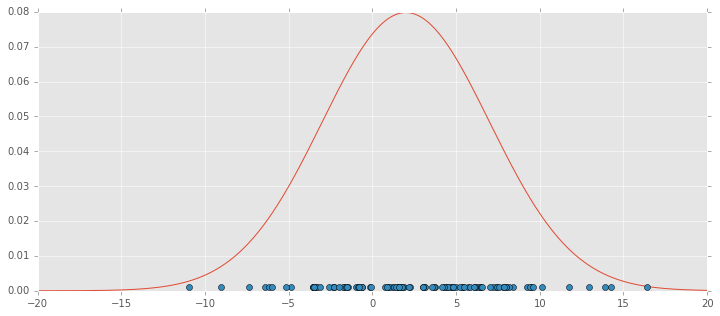

In [177]:
x_axis = np.linspace(-20, 20, 1000)

# Plot real (unknown) distribution together with the i.i.d sample
plt.figure(figsize=(12, 5))
plt.plot(x_axis, norm.pdf(x_axis, mu, sd))
plt.plot(x, [0.001] * len(x), 'o')

The probability of two independent events $X, Y$ is given by the product of their marginals, i.e., $p(X,Y)=P(X)P(Y)$. Since each $x_n \in \boldsymbol{x}$ is independent, the probability of $p(x_1,\dots,x_N)$ is calculated as $p(x_1)\times p(x_2)\times \dots p(x_N)$, where $p(x_n)=\mathcal{N}(x_n\mid \mu,\sigma^2)$ since each $x_n$ comes from a normal distribution. This can be expressed as:

$$ p(\boldsymbol{x} \mid \mu, \sigma^2) = \prod_{n=1}^N \mathcal{N}(x_n \mid \mu, \sigma^2) = \prod_{n=1}^N \frac{1}{\sqrt{2\pi \sigma^2}}exp(-(x_n-\mu)^2/2\sigma^2)$$

where $p(\boldsymbol{x} \mid \mu, \sigma^2)$ is the **likelihood function** of $\boldsymbol{x}$. However, we can't calculate the value of the likelihood function since the parameters of the distribution are unknown ($\mu, \sigma^2$). But using the sample $\boldsymbol{x}$, we can try to estimate these parameters by looking for the values of the parameters that maximize the likelihood function. This is called **Maximum Likelihood Estimation (MLE)**, and can be easily calculated analytically in this case. But before calculating the exact value of the MLE estimations for $\mu$ and $\sigma^2$, let's try a bruteforce approach first. The idea would be this:

* 1 - Implement the likelihood function in python
* 2 - Use a general optimization method to find the values for $\mu$ and $\sigma^2$ (f*ck you maths)


In [163]:
def likelihood(x, mu, sigma2):
    probs = (1/(2*np.pi*sigma2))*np.exp(-((x-mu)**2)/(2*sigma2))
    return np.prod(probs)

Now we can calculate the likelihood of the sample for different values of $\mu$ and $\sigma^2$. Let's see what happens for different values

In [164]:
print(likelihood(x, 0, 1))
print(likelihood(x, 2, 25))
print(likelihood(x, 10, 100))
print(likelihood(x, 10, 100000))

0.0
1.28318647006e-238
1.02675270279e-296
0.0


Wait! something looks wrong. The values we get are very small, and there are some 0's for different values of $\mu$ and $\sigma^2$. Well, let's ignore this for a moment. Remember, we want to find the values that maximize the likelihood function. To do so, we can use differential evolution as our first brute force attemp to find some values. [Differential evolution](http://www1.icsi.berkeley.edu/~storn/code.html) is a beautiful general purpose optimization algorithm that is included in [SciPy](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.differential_evolution.html). This algorithm **minimizes** a given function by looking for different values of the parameters of the function within some provided bounds. Note that maximizing a function $f(x)$ is equal to minimizing the function $-f(x)$, and since we are interested in maximizing the likelihood function, we can define an error function that just returns the negative of the likelihood:

In [172]:
from scipy.optimize import differential_evolution

# Let's find mu using values between -100 and 100, and sigma2 between 0.01 and 100
bounds = [[-100., 100.], [0.01, 100.]]

def error(values):
    mu, sigma = values
    # We want to maximize the likelihood, which is equivalent to minimize
    # the -likelihood
    return -likelihood(x, mu, sigma)

differential_evolution(error, bounds)

     fun: -1.232703101582344e-229
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 1
 success: True
       x: array([  3.03657142,  16.53659729])

The solution that we obtain with this is not close to the real values we expect to obtain. Also, every time we run this we obtain different and incorrect solution. Why is that? The problem is in the multiplication in the likelihood function, since when we multiply many big or small numbers the result produces a floating point overflow. One way to fix this is transforming the product into a summation by applying the log function, and maximizing the log-likelihood function instead of the likelihood function. The parameters that maximize the log-likelihood are the same for the original likelihood function. Why? [Wikipedia](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood) explains this quite well:

> For many applications, the natural logarithm of the likelihood function, called the log-likelihood, is more convenient to work with. **Because the logarithm is a monotonically increasing function, the logarithm of a function achieves its maximum value at the same points as the function itself**, and hence the log-likelihood can be used in place of the likelihood in maximum likelihood estimation and related techniques. Finding the maximum of a function often involves taking the derivative of a function and solving for the parameter being maximized, and this is often easier when the function being maximized is a log-likelihood rather than the original likelihood function.

We need some basic calculus to obtain the log-likelihood. Let's do it!

$$ log(p(\boldsymbol{x} \mid \mu, \sigma^2)) = log\Bigg(\prod_{n=1}^N \frac{1}{\sqrt{2\pi \sigma^2}}exp(-(x_n-\mu)^2/2\sigma^2)\Bigg) = \sum_{n=1}^N log \Bigg( \frac{1}{\sqrt{2\pi \sigma^2}}exp(-(x_n-\mu)^2/2\sigma^2) \Bigg) = $$

$$ = \sum_{n=1}^N \Bigg(log \Big(\frac{1}{\sqrt{2\pi \sigma^2}}\Big) -(x_n-\mu)^2/2\sigma^2 \Bigg) = \sum_{n=1}^N \Bigg(log(1) - log((2\pi \sigma^2)^{1/2}) -(x_n-\mu)^2/2\sigma^2 \Bigg) = $$

$$ = -\sum_{n=1}^N (x_n - \mu)^2/2\sigma^2 - \frac{N}{2}log(2\pi\sigma^2) = -\frac{1}{2\sigma^2}\sum_{n=1}^N (x_n-\mu)^2 - \frac{N}{2}log(\sigma^2)-\frac{N}{2}log(2\pi) $$

Now that we know the expression of the log-likelihood, we can implement it with Python and find the parameters using the same strategy

In [174]:
def loglikelihood(x, mu, sigma2):
    return -(1/(2*sigma2))*np.sum((x-mu)**2) - (1/2)*len(x)*np.log(sigma2)

def error2(values):
    mu, sigma = values
    # We want to maximize the likelihood, which is equivalent to minimize
    # the -likelihood
    return -loglikelihood(x, mu, sigma)

differential_evolution(error2, bounds)

     fun: 201.28466940784182
     jac: array([ 0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 381
     nit: 11
 success: True
       x: array([  2.6610744 ,  20.60828806])

Interestingly (or not?), the values for $\mu$ and $\sigma^2$ that we obtained correspond with the mean and the variance of the sample $\boldsymbol{x}$. Let's check this:

In [175]:
np.mean(x), np.std(x)**2

(2.6610741209244009, 20.608289301975191)

This should mean that the MLE estimators for $\mu$ and $\sigma^2$ are:

* $ \hat{\mu}_{MLE} = \frac{\sum_{n=1}^N x_n}{N} $
* $ \hat{\sigma}^2_{MLE} = \frac{\sum (x_n - \bar{x})^2}{N}$

Is this right? We'll need more maths to check this. We can obtain the exact values by taking the derivative of the log-likelihood and setting to 0:

$$\frac{\partial}{\partial \mu}log(p(\boldsymbol{x} \mid \mu, \sigma^2)) = -\frac{1}{2\sigma^2}\frac{\partial}{\partial \mu}\sum_{n=1}^N(x_n - \mu)^2 - \underbrace{ \frac{\partial}{\partial \mu} \frac{N}{2}log(\sigma^2) }_{\text{constant}} - \underbrace{\frac{\partial}{\partial \mu}\frac{N}{2}log(2\pi)}_{\text{constant}}$$ 

Since $\frac{\partial}{\partial x}$ is a linear map, $\frac{\partial}{\partial x}\sum f(x) = \sum \frac{\partial}{\partial x} f(x)$, hence:

$$-\frac{1}{2\sigma^2}\frac{\partial}{\partial \mu}\sum_{n=1}^N(x_n - \mu)^2 = -\frac{1}{2\sigma^2} \sum \underbrace{\frac{\partial}{\partial \mu} (x_n - \mu)^2}_{\text{chain rule}} = -\frac{1}{2\sigma^2} \sum 2(x_n - \mu)(-1) = \frac{1}{\sigma^2}\sum_{n=1}^N (x_n - \mu)$$

Setting the expression to 0:

$$ \frac{1}{\sigma^2}\sum_{n=1}^N (x_n - \mu) = 0 \implies \sum_{n=1}^N(x_n - \mu) = 0 \implies \sum_{n=1}^N x_n - \underbrace{\sum_{n=1}^N \mu}_{N\mu} = 0 \implies \mu = \frac{\sum_{n=1}^N x_n}{N}$$ 